In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import proplot as pplot
import matplotlib.pyplot as plt
import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cnmaps import get_map, draw_map
from pyproj import transform
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from shapely.geometry import mapping

import os
os.chdir('/Users/zeqinhuang/Documents/paper/HW_track')

import warnings
warnings.filterwarnings('ignore')

In [2]:
def sel_domain(dataarray):
    try:
        dataarray = dataarray.rename({'longitude':'lon','latitude':'lat'}) # for era5
    except:
        pass
    data_dom = dataarray.sel(lat = slice(35,25),lon = slice(100,122.5)) # for YRB
    return data_dom

In [3]:
T2m_anomalies_YRB_obs_1979_2022 = xr.open_dataarray('data/T2m_5day_running_anomalies_era5_D1_1979_2022_MJJAS.nc')
T2m_anomalies_YRB_obs_1979_2022 = sel_domain(T2m_anomalies_YRB_obs_1979_2022)
JJA = T2m_anomalies_YRB_obs_1979_2022.time.dt.month.isin(range(6,9))
T2m_anomalies_YRB_obs_1979_2022_JJA = T2m_anomalies_YRB_obs_1979_2022.sel(time=JJA)
T2m_anomalies_YRB_obs_2022 = T2m_anomalies_YRB_obs_1979_2022_JJA.sel(time=T2m_anomalies_YRB_obs_1979_2022_JJA.time.dt.year==2022)
weights = np.cos(np.deg2rad(T2m_anomalies_YRB_obs_2022.lat))
weights.name = 'weights'
T2m_anomalies_YRB_obs_2022_weighted = T2m_anomalies_YRB_obs_2022.weighted(weights)
T2m_anomalies_YRB_obs_2022_ts = T2m_anomalies_YRB_obs_2022_weighted.mean(('lon','lat'))

In [4]:
for ds in ['era5','jra55']:
    for d in ['D1','D2','D3']:
        dynamic_t2m_YRB_2022 = xr.open_dataarray('data/dynamic_t2m_2022/dynamic_t2m_' + ds + '_' + d + '_SLP.nc')
        dynamic_t2m_YRB_2022 = sel_domain(dynamic_t2m_YRB_2022)
        weights = np.cos(np.deg2rad(dynamic_t2m_YRB_2022.lat))
        weights.name = 'weights'
        dynamic_t2m_YRB_2022_weighted = dynamic_t2m_YRB_2022.weighted(weights)
        dynamic_t2m_YRB_2022_ts = dynamic_t2m_YRB_2022_weighted.mean(('lon','lat'))
        dynamic_t2m_YRB_2022_ts = dynamic_t2m_YRB_2022_ts.to_numpy()
        dynamic_t2m_YRB_2022_ts = dynamic_t2m_YRB_2022_ts.reshape(20,92)
        if ds == 'era5' and d == 'D1':
            dynamic_t2m_YRB_2022_ts_all = dynamic_t2m_YRB_2022_ts
        else:
            dynamic_t2m_YRB_2022_ts_all = np.vstack([dynamic_t2m_YRB_2022_ts_all,dynamic_t2m_YRB_2022_ts])
    

In [8]:
# calculate observed daily SAT anomalies in YRB from 1979 to 2022 (August)
T2m_anomalies_YRB_obs_1979_2010_JJA = T2m_anomalies_YRB_obs_1979_2022_JJA.sel(time = T2m_anomalies_YRB_obs_1979_2022_JJA.time.dt.year.isin(range(1979,2011)))
weights = np.cos(np.deg2rad(T2m_anomalies_YRB_obs_1979_2010_JJA.lat))
weights.name = 'weights'
T2m_anomalies_YRB_obs_1979_2010_JJA_weighted = T2m_anomalies_YRB_obs_1979_2010_JJA.weighted(weights)
T2m_anomalies_YRB_obs_1979_2010_JJA_ts = T2m_anomalies_YRB_obs_1979_2010_JJA_weighted.mean(('lon','lat'))
T2m_anomalies_YRB_obs_1979_2010_JJA_ts_Aug = T2m_anomalies_YRB_obs_1979_2010_JJA_ts.sel(time=T2m_anomalies_YRB_obs_1979_2010_JJA_ts.time.dt.month==8)
T2m_anomalies_YRB_obs_1979_2010 = T2m_anomalies_YRB_obs_1979_2010_JJA_ts.values

# calculate observed daily SAT anomalies in YRB for 2022
T2m_anomalies_YRB_obs_2022_ts_Aug = T2m_anomalies_YRB_obs_2022_ts.sel(time=T2m_anomalies_YRB_obs_2022_ts.time.dt.month==8)
T2m_anomalies_YRB_obs_2022 = T2m_anomalies_YRB_obs_2022_ts_Aug.values

# calculate CCA constructed daily SAT anomalies in YRB for 2022
dynamic_t2m_YRB_2022 = dynamic_t2m_YRB_2022_ts_all['2022-08-01':'2022-08-31'].to_numpy().reshape((31*120))

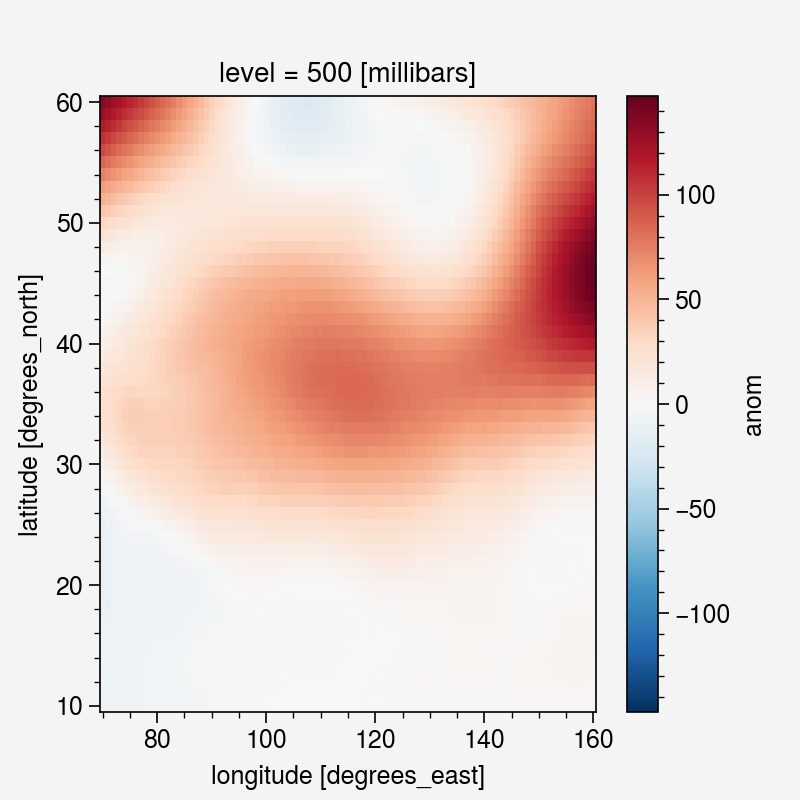

In [9]:
# calculate SLP anomalies
GPH_ano = xr.open_dataarray('data/GPH500_5day_running_anomalies_era5_1979_2022_MJJAS_lat_10_60_lon_70_160.nc')
GPH_ano_2022 = GPH_ano.sel(time=slice('2022-08-01','2022-08-31'))
GPH_ano_2022 = GPH_ano_2022.mean(axis=0)
GPH_ano_2022.plot()

In [10]:
# calculate GPH500
GPH = xr.open_dataarray('/Volumes/Seagate_HZQ/reanalyses/era5/GPH500_daily_era5_2022.nc')
GPH = GPH.sel(latitude = slice(60,10),longitude = slice(70,160))
GPH_2022 = GPH.sel(time=slice('2022-08-01','2022-08-31'))
GPH_2022 = GPH_2022.mean(axis=0)

In [11]:
# calculate August GPH climatology
GPH = xr.open_dataarray('data/GPH500_era5_1979_2022_MJJAS_lat_10_60_lon_70_160.nc')
GPH = GPH.sel(latitude = slice(60,10),longitude = slice(70,160))
GPH = GPH.sel(time = GPH.time.dt.month==8)
GPH_clim = GPH.mean(axis=0)

In [12]:
# calculate u850 and v850
u850 = xr.open_dataarray('data/u850_anomalies_era5_1979_2022_MJJAS_lat_10_60_lon_70_160.nc')
v850 = xr.open_dataarray('data/v850_anomalies_era5_1979_2022_MJJAS_lat_10_60_lon_70_160.nc')
u850 = u850.sel(lat = slice(60,10),lon = slice(70,160))
v850 = v850.sel(lat = slice(60,10),lon = slice(70,160))
u850_2022 = u850.sel(time=slice('2022-08-01','2022-08-31'))
u850_2022 = u850_2022.mean(axis=0)
v850_2022 = v850.sel(time=slice('2022-08-01','2022-08-31'))
v850_2022 = v850_2022.mean(axis=0)

In [13]:
# calculate constructed analogue SAT map (August)
dynamic_t2m_ano_D1 = xr.open_dataarray('data/dynamic_t2m_2022/dynamic_t2m_era5_' + 'D1' + '_SLP.nc')
dynamic_t2m_ano_D2 = xr.open_dataarray('data/dynamic_t2m_2022/dynamic_t2m_era5_' + 'D2' + '_SLP.nc')
dynamic_t2m_ano_D3 = xr.open_dataarray('data/dynamic_t2m_2022/dynamic_t2m_era5_' + 'D3' + '_SLP.nc')
new_lon = dynamic_t2m_ano_D1.lon
new_lat = dynamic_t2m_ano_D1.lat
target_shape = dynamic_t2m_ano_D1.shape
dynamic_t2m_ano_D2_new = np.empty(target_shape)
dynamic_t2m_ano_D3_new = np.empty(target_shape)
dynamic_t2m_ano_D2_new[:,:,:,5:36,10:71] = dynamic_t2m_ano_D2.values
dynamic_t2m_ano_D2_new = xr.DataArray(
    data=dynamic_t2m_ano_D2_new,
    coords=[dynamic_t2m_ano_D1.dist_func,dynamic_t2m_ano_D1.every_other_5day,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
    dims = ['dist_func','every_other_5day','target_time','lat','lon'])
dynamic_t2m_ano_D3_new[:,:,:,10:31,20:61] = dynamic_t2m_ano_D3.values
dynamic_t2m_ano_D3_new = xr.DataArray(
    data=dynamic_t2m_ano_D3_new,
    coords=[dynamic_t2m_ano_D1.dist_func,dynamic_t2m_ano_D1.every_other_5day,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
    dims = ['dist_func','every_other_5day','target_time','lat','lon'])

dynamic_t2m_ano_all = np.empty((target_shape[0]*target_shape[1]*3,) + target_shape[-3:])
dynamic_t2m_ano_all[:20] = dynamic_t2m_ano_D1.values.reshape((20,)+target_shape[-3:])
dynamic_t2m_ano_all[20:40] = dynamic_t2m_ano_D2_new.values.reshape((20,)+target_shape[-3:])
dynamic_t2m_ano_all[40:] = dynamic_t2m_ano_D3_new.values.reshape((20,)+target_shape[-3:])
schemes = range(target_shape[0]*target_shape[1]*3)
dynamic_t2m_ano_all = xr.DataArray(
    data=dynamic_t2m_ano_all,
    coords=[schemes,dynamic_t2m_ano_D1.target_time,dynamic_t2m_ano_D1.lat,dynamic_t2m_ano_D1.lon],
    dims = ['schemes','target_time','lat','lon'])

dynamic_t2m_ano_all_mean = dynamic_t2m_ano_all.mean(axis=0,skipna=True)
dynamic_t2m_ano_all_mean = dynamic_t2m_ano_all_mean.sel(target_time=slice('2022-08-01','2022-08-31'))
dynamic_t2m_ano_all_mean = dynamic_t2m_ano_all_mean.mean(axis=0)

In [14]:
from descartes import PolygonPatch
import shapefile
import matplotlib.path as mpath
import matplotlib.patches as mpatches
source_path = 'shapefiles/country.shp'

Path = mpath.Path
sfile = shapefile.Reader(source_path)
for shape_rec in sfile.shapeRecords():
    vertices = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            vertices.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = mpath.Path(vertices, codes)
    clip = mpatches.PathPatch(clip,visible=False,transform=ccrs.PlateCarree())

Observed YRB SAT anomalies 2022: 1.7
Averaged YRB SAT anomalies 2022 by CCA: 0.81


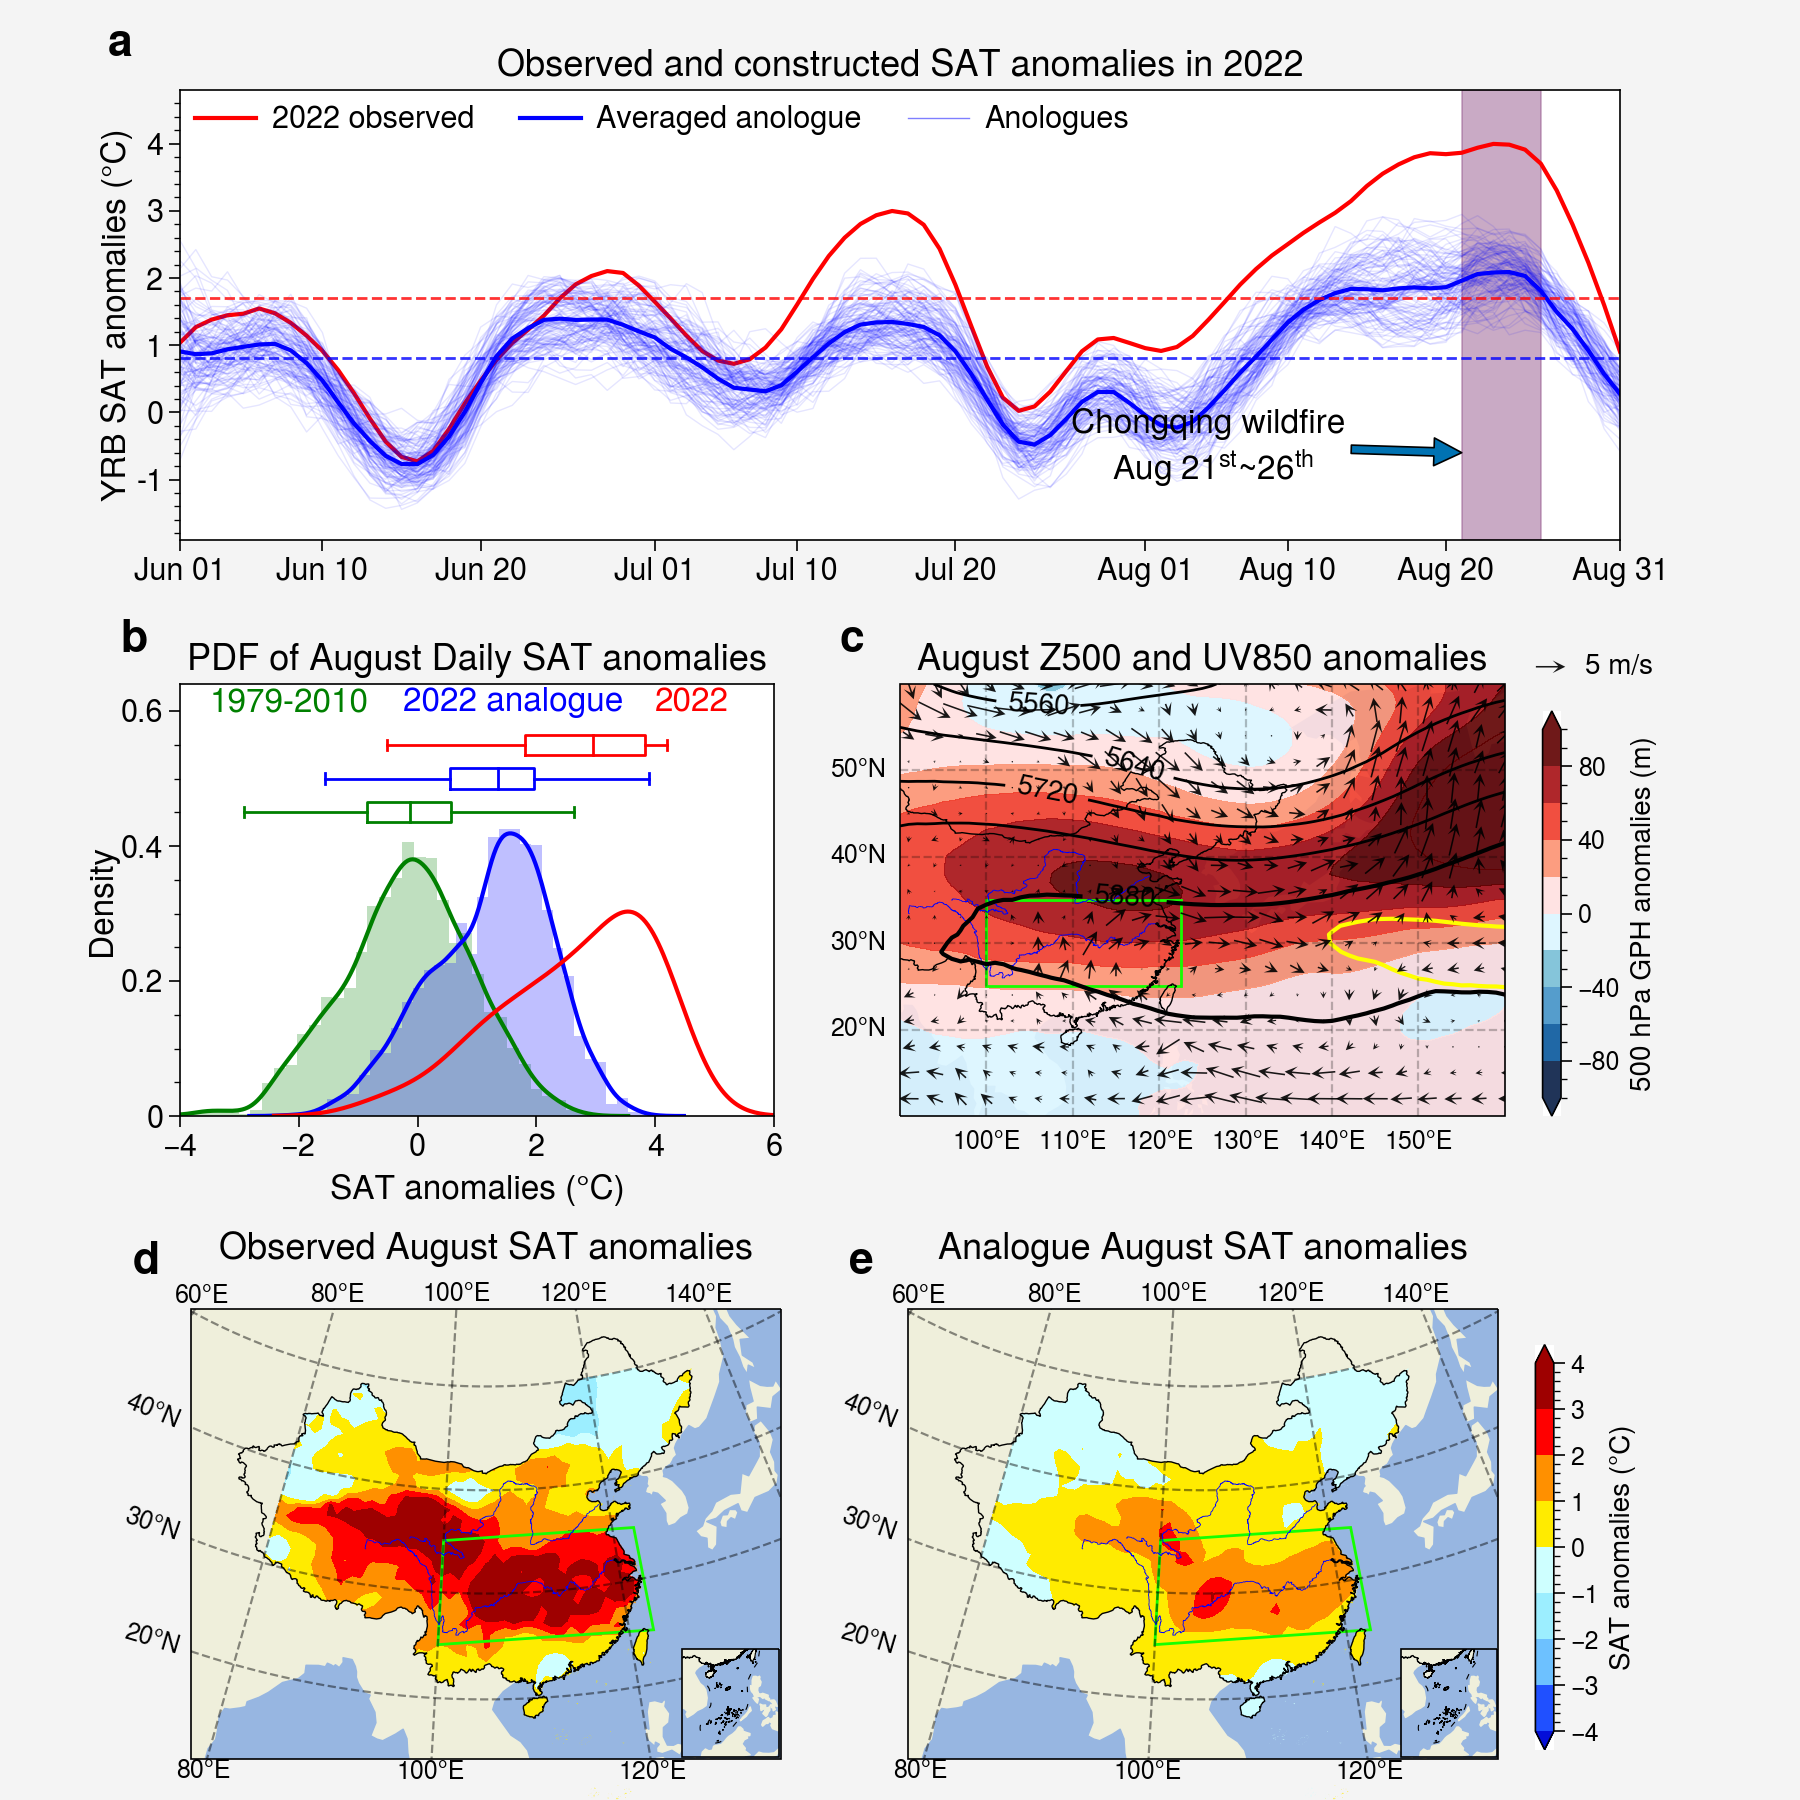

In [15]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
from copy import copy

axes_locs = [
    [0.1,0.7,0.8,0.25],
    [0.1,0.38,0.33,0.24],
    [0.5,0.375,0.42,0.25],
    [0.06,0.023,0.42,0.25],
    [0.496,0.023,0.42,0.25],
]

# data for drawing South China sea
with open('shapefiles/CN-border-L1.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]
    
fig = plt.figure(figsize = (9,9))

# ax1 for CCA 2022
ax1 = fig.add_axes(axes_locs[0])
T2m_obs_2022 = T2m_anomalies_YRB_obs_2022_ts.to_series().rolling(5,min_periods=1).mean()
T2m_averaged_analogue = dynamic_t2m_YRB_2022_ts_all.mean(axis=1).rolling(5,min_periods=1).mean()
l1 = ax1.plot(range(92),T2m_obs_2022, color = 'red')
l2 = ax1.plot(range(92),T2m_averaged_analogue, linewidth = 1.5, color = 'blue')
analogues = dynamic_t2m_YRB_2022_ts_all.rolling(5,min_periods=1).mean()
for i in range(len(analogues.columns)):
    ax1.plot(range(92),analogues[i], alpha = 0.1, linewidth = 0.5, color = 'blue')
ax1.axvspan(81, 86, alpha=0.5, color='purple')
ax1.axhline(y=T2m_obs_2022.mean(),linestyle='--',color='red',alpha=0.8,linewidth=1)
print('Observed YRB SAT anomalies 2022: ' + str(round(T2m_obs_2022.mean(),2)))
ax1.axhline(y=T2m_averaged_analogue.mean(),linestyle='--',color='blue',alpha=0.8,linewidth=1)
print('Averaged YRB SAT anomalies 2022 by CCA: ' + str(round(T2m_averaged_analogue.mean(),2)))
ax1.annotate('Chongqing wildfire\n Aug 21$^{st}$~26$^{th}$',xy=(81,-0.6),xytext=(65,-1),
             arrowprops={"width":3,"headwidth":10,'headlength':10},
             horizontalalignment='center',fontsize=12)
ax1.set_ylabel('YRB SAT anomalies (°C)',fontdict={'fontsize':12},labelpad=1)
ax1.set_xticks([0,9,19,30,39,49,61,70,80,91])
ax1.set_xticklabels(['Jun 01','Jun 10','Jun 20','Jul 01','Jul 10','Jul 20','Aug 01','Aug 10','Aug 20','Aug 31'],fontdict={'fontsize':11})
ax1.set_yticks([-1,0,1,2,3,4])
ax1.set_yticklabels([-1,0,1,2,3,4],fontdict={'fontsize':11})
ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax1.set_xlim((0,91))
ax1.set_ylim((-1.9,4.8))
ax1.grid(False)
ax1.set_title('Observed and constructed SAT anomalies in 2022',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
from matplotlib.lines import Line2D
custom_line = [Line2D([0], [0], color='blue', alpha = 0.5, lw=0.5)]
ax1.legend(
    [l1[0],l2[0],custom_line[0]], ['2022 observed','Averaged anologue','Anologues'],fancybox = True,frameon=False, loc = 'upper left',
    ncol=3,fontsize=11)

# ax2 for PDF of August daily SAT anomalies
import seaborn as sns
ax2 = fig.add_axes(axes_locs[1])

sns.distplot(pd.Series(T2m_anomalies_YRB_obs_1979_2010),ax=ax2,kde=True,color='green',hist_kws={'alpha':0.25})
sns.distplot(pd.Series(dynamic_t2m_YRB_2022),ax=ax2,kde=True, color='blue',hist_kws={'alpha':0.25})
sns.kdeplot(pd.Series(T2m_anomalies_YRB_obs_2022),ax=ax2, color='red')
# flierprops = dict(marker='.', markerfacecolor='gray', markersize=5,alpha=0.3,linestyle='none')
boxprops1 = dict(linestyle='-', linewidth=1, color='green')
boxprops2 = dict(linestyle='-', linewidth=1, color='blue')
boxprops3 = dict(linestyle='-', linewidth=1, color='red')
whiskerprops1 = dict(linestyle='-', linewidth=1, color='green')
whiskerprops2 = dict(linestyle='-', linewidth=1, color='blue')
whiskerprops3 = dict(linestyle='-', linewidth=1, color='red')
capprops1 = dict(linestyle='-', linewidth=1, color='green')
capprops2 = dict(linestyle='-', linewidth=1, color='blue')
capprops3 = dict(linestyle='-', linewidth=1, color='red')
medianprops1 = dict(linestyle='-', linewidth=1, color='green')
medianprops2 = dict(linestyle='-', linewidth=1, color='blue')
medianprops3 = dict(linestyle='-', linewidth=1, color='red')
ax2.boxplot(x = T2m_anomalies_YRB_obs_1979_2010, vert=False, positions=[0.45],widths=0.03,showfliers=False,boxprops=boxprops1,whiskerprops=whiskerprops1,capprops=capprops1,medianprops=medianprops1)
ax2.boxplot(x = dynamic_t2m_YRB_2022, vert=False, positions=[0.5],widths=0.03,showfliers=False,boxprops=boxprops2,whiskerprops=whiskerprops2,capprops=capprops2,medianprops=medianprops2)
ax2.boxplot(x = T2m_anomalies_YRB_obs_2022, vert=False, positions=[0.55],widths=0.03,showfliers=False,boxprops=boxprops3,whiskerprops=whiskerprops3,capprops=capprops3,medianprops=medianprops3)
ax2.text(s='1979-2010',x = -3.5, y=0.6,fontdict={'fontsize':12,'color':'green','fontweight':'medium'})
ax2.text(s='2022 analogue',x = -0.25, y=0.6,fontdict={'fontsize':12,'color':'blue','fontweight':'medium'})
ax2.text(s='2022',x = 4, y=0.6,fontdict={'fontsize':12,'color':'red','fontweight':'medium'})
ax2.set_yticks([0,0.2,0.4,0.6])
ax2.set_yticklabels([0,0.2,0.4,0.6])
ax2.set_ylabel('Density',fontdict={'fontsize':12},labelpad=1)
ax2.tick_params(axis='x',labelsize=11)
ax2.tick_params(axis='y',labelsize=11)
ax2.xaxis.set_tick_params(which='minor', bottom=False)
ax2.set_xlim((-4,6))
ax2.set_ylim((0,0.64))
ax2.grid(False)
ax2.set_title('PDF of August Daily SAT anomalies',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
ax2.set_xlabel('SAT anomalies (°C)',fontdict={'fontsize':12})

# ax3 for GPH and z850 wind anomalies
mapcrs = ccrs.PlateCarree()
river = shpreader.Reader('shapefiles/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.3)
ax3 = fig.add_axes(axes_locs[2],projection=mapcrs)
# ax3.add_feature(cfeature.LAND.with_scale('110m'))
ax3.add_feature(cfeature.OCEAN.with_scale('110m'))
ax3.add_feature(river_feature)
ax3.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,))
ax3.set_title('August Z500 and UV850 anomalies',fontdict={'fontsize':13,'fontweight': 'medium'},y=1)
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)

lon = GPH_ano_2022['longitude']
lat = GPH_ano_2022['latitude']
p1 = ax3.contourf(lon, lat, GPH_ano_2022, cmap=cmaps.temp_diff_18lev, levels=[-100,-80,-60,-40,-20,0,20,40,60,80,100],extend = 'both', transform=ccrs.PlateCarree(),alpha=0.9)
p2 = ax3.contour(lon,lat,GPH_2022,levels=[5880],colors=('black',),linestyles=('-',),linewidths=(1.5,))
ax3.contour(lon,lat,GPH_clim,levels=[5878],colors=('yellow',),linestyles=('-',),linewidths=(1.5,))
p3 = ax3.contour(lon,lat,GPH_2022,levels=[5400,5480,5560,5640,5720,5800],colors=('black',),linestyles=('-',),linewidths=(1,))
ax3.clabel(p2, inline=True, fontsize=10)
ax3.clabel(p3, inline=True, fontsize=10)
fig_cbar = fig.colorbar(p1, ax=ax3, location='right', anchor=(0, 0.2), shrink = 0.9, extend = 'both')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('500 hPa GPH anomalies (m)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

p4 = ax3.quiver(
        lon[::3], lat[::3], u850_2022[::3,::3], v850_2022[::3,::3],color='black',
        pivot='middle',alpha=0.9,headlength=8,headwidth = 8,minshaft=1,zorder=3)
ax3.quiverkey(p4, 1.1, 1.04, 5, r'5 m/s', labelpos='E', fontproperties={'size':10},)

gl1 = ax3.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.25, linestyle='--', draw_labels=True)
ax3.set_extent([90, 160, 10, 55])
gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
gl1.right_labels = False
gl1.top_labels = False

sub_axes_locs = [
    [0.4-0.029, 0.024, 0.07, 0.06],
    [0.8-0.03, 0.024, 0.07, 0.06]
]
# ax4 for spatial distribution of observed SAT anomalies
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
ax4 = fig.add_axes(axes_locs[3], projection = mapcrs)
ax4.add_feature(cfeature.LAND.with_scale('110m'))
ax4.add_feature(cfeature.OCEAN.with_scale('110m'))
ax4.add_feature(river_feature)
ax4.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
ax4.set_extent([78, 132, 13, 55])
ax4.set_title('Observed August SAT anomalies',fontdict={'fontsize':13,'fontweight': 'medium'},y=1.08)
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)

sub_ax = fig.add_axes(sub_axes_locs[0], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

T2m_anomalies_YRB_obs_1979_2022 = xr.open_dataarray('data/T2m_5day_running_anomalies_era5_D1_1979_2022_MJJAS.nc')
T2m_obs_ano_2022 = T2m_anomalies_YRB_obs_1979_2022.sel(time = slice('2022-08-01','2022-08-31'))
T2m_obs_ano_2022 = T2m_obs_ano_2022.mean(axis=0)
lon = T2m_obs_ano_2022['lon']
lat = T2m_obs_ano_2022['lat']
clip_copy = copy(clip)
ax4.add_patch(clip_copy)
p4 = ax4.contourf(lon, lat, T2m_obs_ano_2022, cmap=cmaps.GMT_panoply, levels=[-4,-3,-2,-1,0,1,2,3,4],extend = 'both', transform=ccrs.PlateCarree())
for c in p4.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl4.xlabel_style = {'rotation': 0, 'ha':'center'}
gl4.right_labels = False

# ax5 for CCA constructed SAT
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
ax5 = fig.add_axes(axes_locs[4], projection = mapcrs)
ax5.add_feature(cfeature.LAND.with_scale('110m'))
ax5.add_feature(cfeature.OCEAN.with_scale('110m'))
ax5.add_feature(river_feature)
ax5.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
ax5.set_extent([78, 132, 13, 55])
ax5.set_title('Analogue August SAT anomalies',fontdict={'fontsize':13,'fontweight': 'medium'},y=1.08)
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)

sub_ax = fig.add_axes(sub_axes_locs[1], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

clip_copy = copy(clip)
ax5.add_patch(clip_copy)
p4 = ax5.contourf(lon, lat, dynamic_t2m_ano_all_mean, cmap=cmaps.GMT_panoply, levels=[-4,-3,-2,-1,0,1,2,3,4],extend = 'both', transform=ccrs.PlateCarree())
for c in p4.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

fig_cbar = fig.colorbar(p4, ax=ax5, location='right', anchor=(0, 0.2), shrink = 0.9, extend = 'both')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('SAT anomalies (°C)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl5.xlabel_style = {'rotation': 0, 'ha':'center'}
gl5.right_labels = False
 

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='left')

add_panel_label(ax1, 'a', x=-0.05, y = 1.15)
add_panel_label(ax2, 'b', x=-0.1, y = 1.15)
add_panel_label(ax3, 'c', x=-0.1, y = 1.15)
add_panel_label(ax4, 'd', x=-0.1, y = 1.15)
add_panel_label(ax5, 'e', x=-0.1, y = 1.15)

plt.tight_layout()
plt.savefig("Figures/Fig3_2022_CCA_construct_SLP.pdf",bbox_inches='tight')
fig.savefig('Figures/Fig3_2022_CCA_construct_SLP.png',bbox_inches='tight')